EMG Signal prediction

In [11]:
import sys
import json
import datetime
import build_model
import data_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from shutil import copyfile
import os
import pathlib

In [3]:
# Define basic training parameters 
train_file = "./data/pdmaria1_emg.csv"
parameter_file = "./training_config.json"
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Load training parameters
with open(parameter_file) as f:
    params = json.load(f)
    print(params)

output_path = params['output_path']
pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)
    
backup_copy = output_path + "training_config_" + timestamp + ".json"
copyfile(parameter_file, backup_copy)

{'output_path': './saved_models/1-point/lstm/', 'moving_avg_window': 100, 'epochs': 5, 'batch_size': 1000, 'timesteps': 400, 'activation_function': 'tanh', 'leaky_alpha': 0.3, 'min_max': [-1.0, 1.0], 'loss_function': 'mse', 'optimizer': 'adam', 'train_test_split': 0.8, 'validation_split': 0.1, 'regularization_l1': 0.0, 'regularization_l2': 0.0, 'dropout_keep_prob': 0.0, 'model': 'rnn_lstm', 'encoder_model': '', 'input_dimensions': 3, 'hidden_units': [50], 'dense_units': [1], 'prediction_timesteps': 1, 'prediction_lag': 0}


'./saved_models/1-point/lstm/training_config_2020_06_04_23_17_47.json'

Load data set and split into training and test data

In [4]:
#Loading EMG Signals - using only 1 EMG signal
x_series = ["FLEXOR_EMG_FILTERED"]
params['data_dim'] = len(x_series)

X = data_helper.load_timeseries(train_file, x_series)
#print(X.head)

#Rescale data before hand
min_max = params['min_max']
X_values = X.values
X_normalized, scalers = data_helper.min_max(X_values,min_max[0],min_max[1])

#Sample sliding windows from data
X_windows = data_helper.get_windows(X_normalized,params['timesteps'])
X = np.array(X_windows)

#Prediction of EMG variable, #prediction_timesteps points in the future
Y_windows = data_helper.get_windows(X_normalized,params['prediction_timesteps'])
Y = np.array(Y_windows)

#Shift windows to predict the future
X = X[0:-params['timesteps']-params['prediction_lag']]
Y = Y[params['timesteps']+params['prediction_lag']:] #shift window size

split_ratio = round(params['train_test_split'] * X.shape[0])

# Load time series dataset, and split it into train and test
x_train, y_train, x_test, y_test, perm = data_helper.get_sampled_data(X,Y,split_ratio)

if params['input_dimensions'] == 2:
    #Reshape to 2 dimensions (batch_samples, sliding_window_size)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1]))
    
y_test = np.reshape(y_test, (y_test.shape[0],y_test.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1]))

Visualize training data set

In [5]:
print('Training data set sample - X: ' + str(x_train[0,:]))
print('Training data set sample - Y: ' + str(y_train[0,:]))

Training data set sample - X: [[-4.98886079e-02]
 [-5.09242534e-02]
 [-5.31731696e-02]
 [-5.51691956e-02]
 [-5.59278661e-02]
 [-5.47657755e-02]
 [-5.19598988e-02]
 [-4.90802625e-02]
 [-4.65031912e-02]
 [-4.31930395e-02]
 [-3.87719774e-02]
 [-3.42741450e-02]
 [-3.03829480e-02]
 [-2.67702312e-02]
 [-2.38890896e-02]
 [-2.24996989e-02]
 [-2.21715438e-02]
 [-2.20706888e-02]
 [-2.22723988e-02]
 [-2.20962789e-02]
 [-2.08318280e-02]
 [-1.87605371e-02]
 [-1.67389210e-02]
 [-1.47188102e-02]
 [-1.22170039e-02]
 [-9.20941715e-03]
 [-5.82400048e-03]
 [-2.33772881e-03]
 [ 1.30057803e-03]
 [ 4.00409441e-03]
 [ 4.30816474e-03]
 [ 2.48825867e-03]
 [-3.76324663e-05]
 [-2.76673892e-03]
 [-5.62229046e-03]
 [-8.95803227e-03]
 [-1.29741691e-02]
 [-1.71935212e-02]
 [-2.11358984e-02]
 [-2.43196050e-02]
 [-2.60883309e-02]
 [-2.66949663e-02]
 [-2.68710862e-02]
 [-2.70983863e-02]
 [-2.77050217e-02]
 [-2.81340318e-02]
 [-2.82348868e-02]
 [-2.83613319e-02]
 [-2.87150771e-02]
 [-2.94993377e-02]
 [-3.04341281e-02]
 

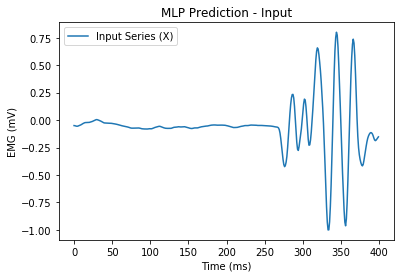

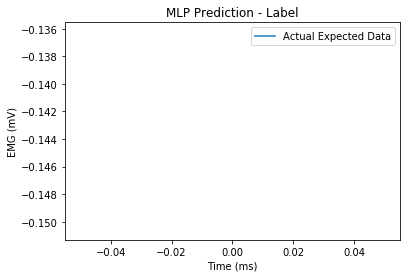

In [6]:
# Plot graph: input
plt.figure()
plt.plot(x_train[0,:], label='Input Series (X)')
plt.title('MLP Prediction - Input')
plt.xlabel('Time (ms)')
plt.ylabel('EMG (mV)')
plt.legend()
plt.show()

# Plot graph: predicted VS actual
plt.figure()
plt.plot(y_train[0,:], label='Actual Expected Data')
plt.title('MLP Prediction - Label')
plt.xlabel('Time (ms)')
plt.ylabel('EMG (mV)')
plt.legend()
plt.show()

Create model based on loaded configuration parameters

In [8]:
hist = None
model = None
model = build_model.create_model(params)

# serialize model to JSON
model_json = model.to_json()
with open(output_path + "model_" + timestamp +".json", "w") as json_file:
	json_file.write(model_json)
file_name = output_path + 'model_' + timestamp + '.png'
plot_model(model, to_file=file_name, show_shapes = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 1)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Pre-encode the model - if using Autoencoder approach

In [9]:
if params['encoder_model']:
    encoder_model = model.load(params['encoder_model'])
    x_train = encoder_model.predict(x_train)
    x_test = encoder_model.predict(x_test)

 Train the model

In [10]:
#define callbacks
file_name = output_path + 'weights-checkpoint_' + timestamp + '.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs/' + timestamp, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=1)
callbacks_list = [checkpoint, tensor_board, reduce_lr, early_stopping]

start_time = datetime.datetime.now()

# Train given model with train set
hist = model.fit(
        x_train,
        y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_split=params['validation_split'],
        callbacks=callbacks_list, verbose=1)

end_time = datetime.datetime.now()
total_time = end_time - start_time
print("Training time: {}".format(str(total_time)))

# serialize model to HDF5
model.save(output_path + "model_" + timestamp + '.hdf5')
print("Saved model to disk")

file_name = output_path + 'model_' + timestamp + '.png'
plot_model(model, to_file=file_name, show_shapes = True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 83233 samples, validate on 9249 samples


Epoch 1/5
83233/83233 [==============================] - 176s 2ms/step - loss: 0.0096 - acc: 0.0000e+00 - rmse: 0.0953 - val_loss: 0.0039 - val_acc: 0.0000e+00 - val_rmse: 0.0623

Epoch 00001: loss improved from inf to 0.00964, saving model to ./saved_models/1-point/lstm/weights-checkpoint_2020_06_04_23_17_47.hdf5
Epoch 2/5
83233/83233 [==============================] - 220s 3ms/step - loss: 0.0020 - acc: 2.4029e-05 - rmse: 0.0446 - val_loss: 0.0014 - val_acc: 0.0000e+00 - val_rmse: 0.0376

Epoch 00002: loss improved from 0.00964 to 0.00205, saving model to ./saved_models/1-point/lstm/weights-checkpoint_2020_06_04_23_17_47.hdf5
Epoch 3/5
83233/83233 [==============================] - 225s 3ms/step - loss: 0.0015 - acc: 2.4029e-05 - rmse: 0.0375 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_rmse: 0.0361

Epoch 00003: loss improved from 0.002

Test model against test data set

In [12]:
predicted = model.predict(x_test)

#Save samples
np.savetxt(output_path + "predicted_" + timestamp + ".csv", predicted, delimiter=",")
np.savetxt(output_path + "test_" + timestamp + ".csv", y_test, delimiter=",")

#Calculate RMSE for test prediction
test_mse = mean_squared_error(y_test[0:predicted.shape[0]], predicted)
test_rmse = sqrt(test_mse)
print('Test MSE: %.4f' % test_mse)
print('Test RMSE: %.4f' % test_rmse)

Test MSE: 0.0010
Test RMSE: 0.0315


Plot prediction results

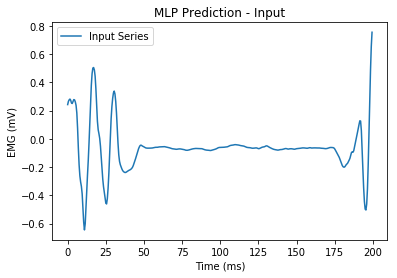

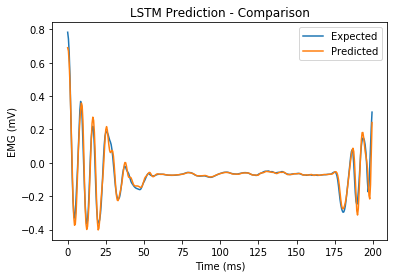

In [13]:
x_time = np.arange(400) / 2000 * 1000

# Plot graph: input
file_name = output_path + 'input_' + timestamp + '.png'
plt.figure()
plt.plot(x_time, x_test[0,:], label='Input Series')
plt.title('MLP Prediction - Input')
plt.xlabel('Time (ms)')
plt.ylabel('EMG (mV)')
plt.legend()
plt.savefig(file_name)
plt.show()

# Plot graph: predicted VS actual
file_name = output_path + 'predicted_' + timestamp + '.png'
plt.figure()
plt.plot(x_time, y_test[0:params['timesteps'],:], label='Expected')
plt.plot(x_time, predicted[0:params['timesteps'],:], label='Predicted')
plt.title('LSTM Prediction - Comparison')
plt.xlabel('Time (ms)')
plt.ylabel('EMG (mV)')
plt.legend()
plt.savefig(file_name)
plt.show()